In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
from utils import scatter_plot, qqplot

In [2]:
ifmha = pd.read_csv('./tauraat-230322-150349.csv', converters={'site_no': str}, low_memory=False)
hydro_subset = pd.read_csv('./data/hydroswot-subset-230329-120803.csv', converters={'site_no': str}, low_memory=False)

In [3]:
sites = hydro_subset['site_no'].value_counts()
hydro_stat = hydro_subset[hydro_subset["site_no"].isin(sites.index[sites>=30].to_list())]

print("site locations with minimum of 30 observations: ")
print(f'Number of observations: {hydro_stat.shape}')
print('Number of sites:')
sites = hydro_stat['site_no'].value_counts()
sites.describe()

site locations with minimum of 30 observations: 
Number of observations: (7666, 7)
Number of sites:


count    174.000000
mean      44.057471
std       23.867581
min       30.000000
25%       33.000000
50%       37.000000
75%       44.000000
max      159.000000
Name: site_no, dtype: float64

In [4]:
pct = 0.01
stat_dist = [] # statistical distance
for idx, site in enumerate(sites):
    if sites.index[idx] in ifmha['site_no'].tolist():
        data1 = hydro_subset[hydro_subset['site_no'] == sites.index[idx]]['mean_depth_va']
        data1 = data1[(data1 > data1.quantile(pct)) & (data1 < data1.quantile(1-pct))].values

        data2 = ifmha[ifmha['site_no'] == sites.index[idx]]['chan_mean_depth']
        data2 = data2[(data2 > data2.quantile(pct)) & (data2 < data2.quantile(1-pct))].values
    else:
        print(f'site number: {sites.index[idx]} is not in IFMHA!')
        continue

    max_val = np.max(np.hstack((data1, data2)))
    min_val = np.min(np.hstack((data1, data2)))
    q, _ = np.histogram(data1, range=(min_val, max_val), density=True)
    p, _ = np.histogram(data2, range=(min_val, max_val), density=True)
    stat_dist.append(jensenshannon(p, q))


    print(f'site number: {sites.index[idx]}, Jensen-Shannon Divergence: {jensenshannon(p, q):.4f}, HYDRoSWOT: {data1.shape[0]}, IFMHA: {data2.shape[0]}')
    # qqplot(data1, data2)

site number: 02239501, Jensen-Shannon Divergence: 0.2686, HYDRoSWOT: 155, IFMHA: 392
site number: 06893000, Jensen-Shannon Divergence: 0.1598, HYDRoSWOT: 151, IFMHA: 1703
site number: 06813500 is not in IFMHA!
site number: 06610000, Jensen-Shannon Divergence: 0.3249, HYDRoSWOT: 136, IFMHA: 5345
site number: 06807000, Jensen-Shannon Divergence: 0.3050, HYDRoSWOT: 130, IFMHA: 6448
site number: 06601200, Jensen-Shannon Divergence: 0.2701, HYDRoSWOT: 128, IFMHA: 2932
site number: 06486000, Jensen-Shannon Divergence: 0.2472, HYDRoSWOT: 126, IFMHA: 5367
site number: 06818000, Jensen-Shannon Divergence: 0.1415, HYDRoSWOT: 107, IFMHA: 1368
site number: 06895500, Jensen-Shannon Divergence: 0.1958, HYDRoSWOT: 101, IFMHA: 1283
site number: 06909000, Jensen-Shannon Divergence: 0.2220, HYDRoSWOT: 101, IFMHA: 1290
site number: 06934500, Jensen-Shannon Divergence: 0.1951, HYDRoSWOT: 83, IFMHA: 1076
site number: 07374525, Jensen-Shannon Divergence: 0.1705, HYDRoSWOT: 73, IFMHA: 271
site number: 073740

In [6]:
js_divergence_mean_depth = np.array(stat_dist)

In [9]:
pct = 0.01
stat_dist = [] # statistical distance

for idx, site in enumerate(sites):
    if sites.index[idx] in ifmha['site_no'].tolist():
        data1 = hydro_subset[hydro_subset['site_no'] == sites.index[idx]]['max_depth_va']
        data1 = data1[(data1 > data1.quantile(pct)) & (data1 < data1.quantile(1-pct))].values

        data2 = ifmha[ifmha['site_no'] == sites.index[idx]]['chan_max_depth']
        data2 = data2[(data2 > data2.quantile(pct)) & (data2 < data2.quantile(1-pct))].values
    else:
        print(f'{sites.index[idx]} is not in IFMHA!')
        continue

    max_val = np.max(np.hstack((data1, data2)))
    min_val = np.min(np.hstack((data1, data2)))
    q, _ = np.histogram(data1, range=(min_val, max_val), density=True)
    p, _ = np.histogram(data2, range=(min_val, max_val), density=True)
    stat_dist.append(jensenshannon(p, q))

    print(f'site number: {sites.index[idx]}, Jensen-Shannon Divergence: {jensenshannon(p, q):.4f}, HYDRoSWOT: {data1.shape[0]}, IFMHA: {data2.shape[0]}')
    # qqplot(data1, data2)

    # max_val = np.max(np.hstack((data1, data2)))
    # min_val = np.min(np.hstack((data1, data2)))
    # fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
    # ax1.hist(data1, range=(min_val, max_val), density=True)
    # ax2.hist(data2, range=(min_val, max_val), density=True)
    # plt.show()

site number: 02239501, Jensen-Shannon Divergence: 0.4352, HYDRoSWOT: 155, IFMHA: 392
site number: 06893000, Jensen-Shannon Divergence: 0.1801, HYDRoSWOT: 151, IFMHA: 1703
06813500 is not in IFMHA!
site number: 06610000, Jensen-Shannon Divergence: 0.3484, HYDRoSWOT: 136, IFMHA: 5345
site number: 06807000, Jensen-Shannon Divergence: 0.2434, HYDRoSWOT: 130, IFMHA: 6448
site number: 06601200, Jensen-Shannon Divergence: 0.1941, HYDRoSWOT: 128, IFMHA: 2932
site number: 06486000, Jensen-Shannon Divergence: 0.2972, HYDRoSWOT: 126, IFMHA: 5367
site number: 06818000, Jensen-Shannon Divergence: 0.1923, HYDRoSWOT: 107, IFMHA: 1368
site number: 06895500, Jensen-Shannon Divergence: 0.2728, HYDRoSWOT: 101, IFMHA: 1283
site number: 06909000, Jensen-Shannon Divergence: 0.2768, HYDRoSWOT: 101, IFMHA: 1290
site number: 06934500, Jensen-Shannon Divergence: 0.2758, HYDRoSWOT: 83, IFMHA: 1076
site number: 07374525, Jensen-Shannon Divergence: 0.4004, HYDRoSWOT: 73, IFMHA: 271
site number: 07374000, Jensen-Sh

In [10]:
js_divergence_max_depth = np.array(stat_dist)

In [16]:
js_divergence_mean_depth[js_divergence_mean_depth<0.15]

array([0.14148717, 0.13866512, 0.14545945, 0.13523011, 0.13696558,
       0.12443781, 0.11347344])

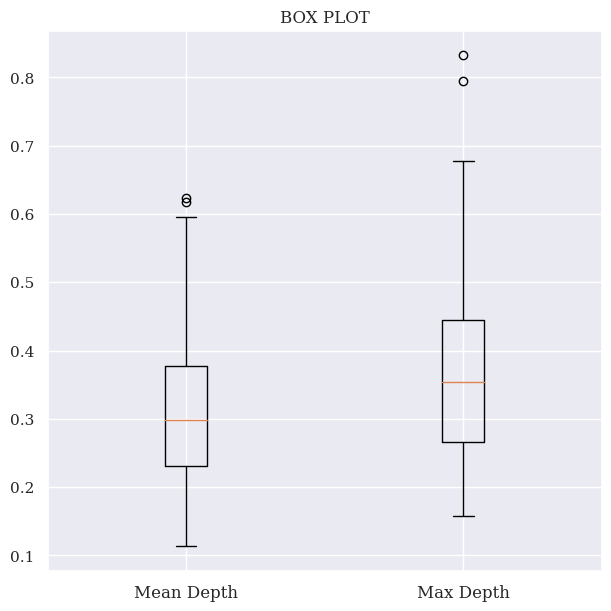

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), constrained_layout=True)

ax.boxplot([js_divergence_mean_depth, js_divergence_max_depth])
ax.set_xticklabels(['Mean Depth', 'Max Depth'])
ax.tick_params(axis='x', labelrotation=0, labelsize=12)
ax.grid(True)
ax.set_title(f'BOX PLOT')

plt.show()

In [10]:
def qqplot(y_test, y_pred, site_name=None, quantiles=None):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True)

    ax1.boxplot([y_test, y_pred])
    ax1.set_xticklabels(['GT', 'MODEL'])
    ax1.tick_params(axis='x', labelrotation=0, labelsize=12)
    ax1.grid(True)
    ax1.set_title(f'BOX PLOT')

    x1 = np.sort(y_test)
    y1 = np.arange(1, len(y_test) + 1) / len(y_test)
    ax2.plot(x1, y1, linestyle='none', marker='o', alpha=0.2, label='GT')
    # ax2.plot(x1, y1, linestyle='-', alpha=0.8, label='GT')

    x2 = np.sort(y_pred)
    y2 = np.arange(1, len(y_pred) + 1) / len(y_pred)
    # ax1.plot(x2, y2, linestyle='none', marker='.', alpha=0.5, label='GT')
    ax2.plot(x2, y2, linestyle='-.', alpha=1, label='MODEL')

    ax2.set_title(f'ECDF')
    ax2.legend()

    if quantiles is None:
        quantiles = min(len(y_test), len(y_pred))
    quantiles = np.linspace(start=0, stop=1, num=int(quantiles))

    x_quantiles = np.quantile(y_test, quantiles, method='nearest')
    y_quantiles = np.quantile(y_pred, quantiles, method='nearest')
    ax3.scatter(x_quantiles, y_quantiles)

    max_value = np.array((x_quantiles, y_quantiles)).max()
    ax3.plot([0, max_value], [0, max_value], '--', color = 'black', linewidth=1.5)

    ax3.set_xlabel('GT')
    ax3.set_ylabel('MODEL')
    ax3.set_title(f'Q-Q PLOT')

    if site_name is not None:
        plt.savefig(f'./{site_name}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)

    plt.show()

site number: 07010000, Jensen-Shannon Divergence: 0.1703, HYDRoSWOT: 54, IFMHA: 2840


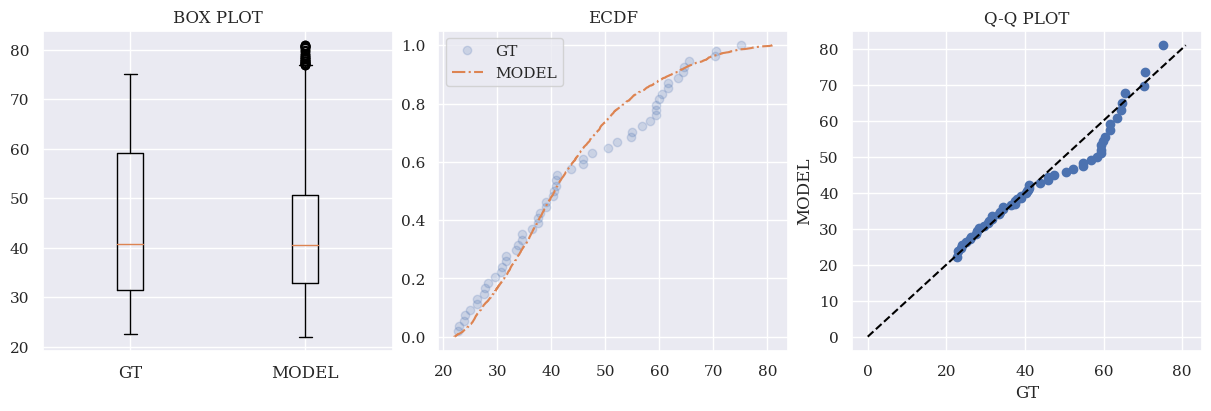

In [17]:
site = '07010000'
pct = 0.01

data1 = hydro_subset[hydro_subset['site_no'] == site]['max_depth_va']
data1 = data1[(data1 > data1.quantile(pct)) & (data1 < data1.quantile(1-pct))].values

data2 = ifmha[ifmha['site_no'] == site]['chan_max_depth']
data2 = data2[(data2 > data2.quantile(pct)) & (data2 < data2.quantile(1-pct))].values

max_val = np.max(np.hstack((data1, data2)))
min_val = np.min(np.hstack((data1, data2)))
q, _ = np.histogram(data1, range=(min_val, max_val), density=True)
p, _ = np.histogram(data2, range=(min_val, max_val), density=True)

print(f'site number: {site}, Jensen-Shannon Divergence: {jensenshannon(p, q):.4f}, HYDRoSWOT: {data1.shape[0]}, IFMHA: {data2.shape[0]}')
qqplot(data1, data2, site_name=site)


In [82]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [85]:
def llv(p, q):
    return - np.sum(p * np.log(q))